<a href="https://colab.research.google.com/github/YaZlob/ML_project/blob/master/Learn_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой работе представлены:

*   Сжимающий автоэкнодер с помощью сверточных слоев
*   Denoising автоэнкодер, убирающий шум с изображений
*   Denoising автоэнкодер для гладкой функции
 



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from copy import deepcopy
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

cuda


Загрузка датасета MNIST

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 32
trainset = torchvision.datasets.MNIST(root='./dataset', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./dataset', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = [i for i in range(10)]

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Функция для отрисовки изображений

In [3]:
def print_data(dataloader,im_count=9):
  fig = plt.figure(figsize=(9,9))
  random_index = np.random.randint(0, len(dataloader),size=im_count)
  
  for i in range(im_count):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, label = dataloader.dataset[random_index[i]]
    image = transforms.ToPILImage(mode='L')(image)
    plt.imshow(image,cmap = "gray")
    a.set_title(f"{label}")

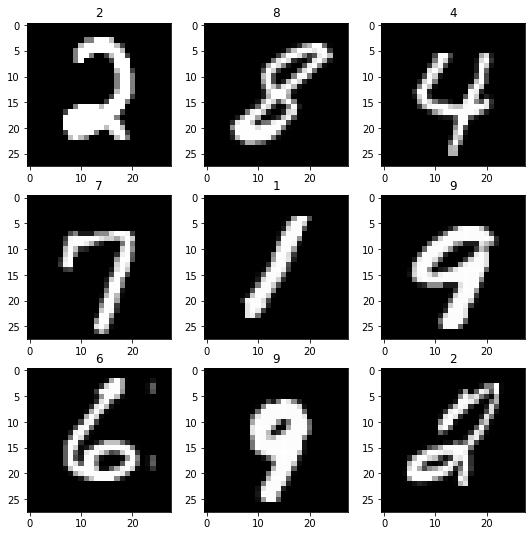

In [4]:
print_data(trainloader)

Реализация простой модели сжимающиего автоэнкодера (создаем свой jpg)

In [5]:
class AutoEncoder(nn.Module):
  def __init__(self):
        super(AutoEncoder, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=3)
        self.pool1 = nn.MaxPool2d((2,2)) #->12x12

        self.conv2 = nn.Conv2d(in_channels=6,out_channels = 16, kernel_size = 3)
        self.pool2 = nn.MaxPool2d((2,2)) # ->5x5


        # Code
        self.code = nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(1,1))

        #Decoder
        self.upsample1 = nn.UpsamplingBilinear2d(size = 10)
        self.decode1 = nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=3)
        self.upsample2 = nn.UpsamplingBilinear2d(size = 26)
        self.decode2 = nn.ConvTranspose2d(in_channels=8, out_channels = 1, kernel_size=3)



  def forward(self,x):
      x.to(device)
      x = self.pool1(F.relu(self.conv1(x)))
      x = self.pool2(F.relu(self.conv2(x)))
      x = F.sigmoid(self.code(x))
      x = F.relu(self.decode1(self.upsample1(x)))
      x = F.sigmoid(self.decode2((self.upsample2(x))))
      return x

Создание объекта модели. Выбор метрики и алгоритма оптимизации градиентного спуска.

In [6]:
model = AutoEncoder()
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Функции для обучения и тестирования модели

In [7]:
def train_mode(model, criterion, optim, loader):
  train_loss = 0
  model.train()

  for image, label in loader:
    image = image.to(device)
    optim.zero_grad()
    pred = model(image)
    loss = criterion(pred,image)
    loss.backward()
    optim.step()
    train_loss += loss.item()
  return train_loss

def test_mode(model, criterion, loader):
  test_loss = 0
  model.eval()
  for image, label in loader:
    image = image.to(device)
    with torch.set_grad_enabled(False):
      pred = model(image)
      loss = criterion(pred,image)
    test_loss += loss.item() 
    
  return test_loss
  

Функция, реализующая цикл обучения модели

In [8]:
def loop(model, criterion, optim, train_loader, test_loader, num_epochs):
  hist = []
  for epoch in (range(num_epochs)):
    train = train_mode(model, criterion, optim, train_loader)
    test = test_mode(model, criterion, test_loader)
    print(f"iteration number:{epoch + 1}")
    print("train loss: {:.5f} | test loss: {:.5f}".format(train, test))
    hist.append((train,test))
    
  return hist

In [9]:
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iteration number:1
train loss: 338.30847 | test loss: 43.81424
iteration number:2
train loss: 248.57025 | test loss: 39.46182
iteration number:3
train loss: 232.08971 | test loss: 37.56282
iteration number:4
train loss: 224.21649 | test loss: 36.69459
iteration number:5
train loss: 219.25922 | test loss: 35.83687
iteration number:6
train loss: 215.79239 | test loss: 35.29897
iteration number:7
train loss: 212.88123 | test loss: 34.89834
iteration number:8
train loss: 210.87153 | test loss: 34.58562
iteration number:9
train loss: 209.13440 | test loss: 34.80966
iteration number:10
train loss: 207.78003 | test loss: 34.10036


Для наглядности представления обучения необходима функция, показывающая изменение функции потерь, т.е. процесс обучение модели

In [10]:
def show_graph(hist):
    train_loss,test_loss = [], []
    for train,test in hist:
        train_loss.append(train)
        test_loss.append(test)
    plot1 = plt.figure(1)
    plt.plot(train_loss)

    plot2 = plt.figure(2)
    plt.plot(test_loss)

    plt.show()

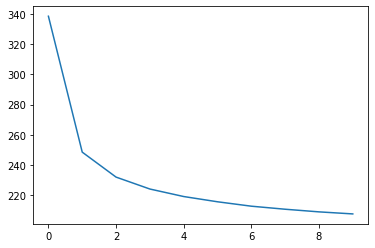

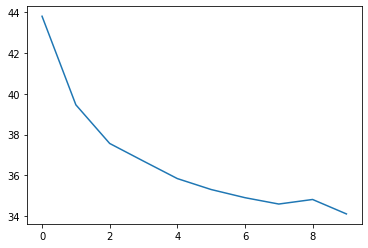

In [11]:
show_graph(hist)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iteration number:1
train loss: 206.25206 | test loss: 33.99491
iteration number:2
train loss: 205.79013 | test loss: 33.91351
iteration number:3
train loss: 205.39895 | test loss: 33.86128
iteration number:4
train loss: 204.98417 | test loss: 33.76825
iteration number:5
train loss: 204.60584 | test loss: 33.86324
iteration number:6
train loss: 204.30141 | test loss: 33.68897
iteration number:7
train loss: 203.93366 | test loss: 33.67060
iteration number:8
train loss: 203.63781 | test loss: 33.55169
iteration number:9
train loss: 203.28093 | test loss: 33.51352
iteration number:10
train loss: 203.00195 | test loss: 33.45527
iteration number:11
train loss: 202.70698 | test loss: 33.43780
iteration number:12
train loss: 202.44310 | test loss: 33.37388
iteration number:13
train loss: 202.18589 | test loss: 33.29684
iteration number:14
train loss: 201.94320 | test loss: 33.28461
iteration number:15
train loss: 201.67785 | test loss: 33.24425
iteration number:16
train loss: 201.45762 | test 

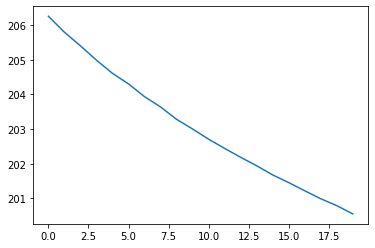

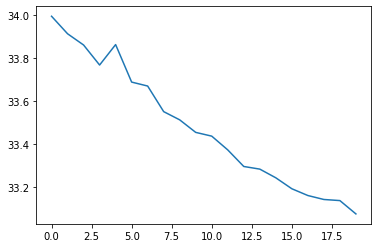

In [12]:
# уменьшим lr, запустим обучаться модель еще на 20 итерациях
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
hist = loop(model,loss_func, optimizer, trainloader,testloader,20)
show_graph(hist)

In [13]:
def check_model_work(model,dataloader):
  plt.figure(figsize=(18, 6))
  random_index = np.random.randint(0, len(dataloader),size=5)
  for i in range(5):
    image, label = dataloader.dataset[random_index[i]]
    im_for_model = deepcopy(image)
    image = transforms.ToPILImage(mode='L')(image)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
    
    image = model(im_for_model.unsqueeze(0))
    image = transforms.ToPILImage(mode='L')(image[0])
    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
  plt.show();

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


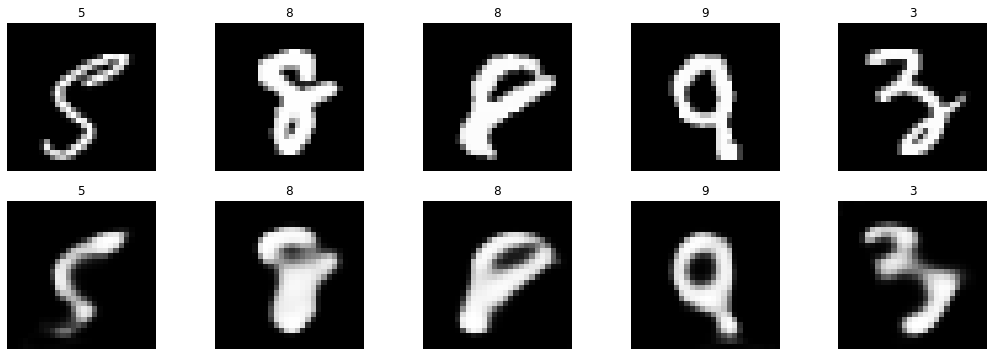

In [14]:
check_model_work(model.cpu(),testloader)

Точность модели можно увеличить, если продолжить обучение еще несколько итераций. Можно изменить lr, изменить количество итеараций, чтобы посмотреть как это повлияет на обучение модели. Я остановлюсь на этом результате, так как убедился, что классические алгоритмы сжатия работают лучше, чем сжимающий автоэнкодер


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,10)
check_model_work(model.cpu(),testloader)

Denoising AutoEncoder

In [15]:
def add_noise(tensor,mean=0.5,std=0.2):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)

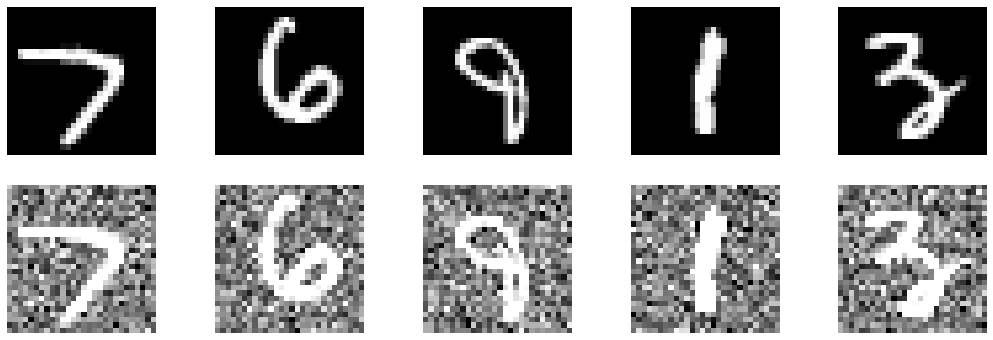

In [16]:
def check_noise_work(dataloader,noiser):
  plt.figure(figsize=(18, 6))
  random_index = np.random.randint(0, len(dataloader),size=5)
  for i in range(5):
    image, label = dataloader.dataset[random_index[i]]
    noise_image = noiser(image)

    image = transforms.ToPILImage(mode='L')(image)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(image,cmap = "gray")

    noise_image = transforms.ToPILImage(mode='L')(noise_image)
    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(noise_image,cmap = "gray")
  plt.show();
check_noise_work(testloader,add_noise)

In [17]:
class NoiseAutoEncoder(nn.Module):
  def __init__(self):
        super(NoiseAutoEncoder, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)

        #Decoder
        self.upsample1 = nn.UpsamplingBilinear2d(size = 5)
        self.decode1 = nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3)
        self.upsample2 = nn.UpsamplingBilinear2d(size = 12)
        self.decode2 = nn.ConvTranspose2d(in_channels=16, out_channels = 8, kernel_size=3)
        self.upsample3 = nn.UpsamplingBilinear2d(size = 24)
        self.decode3 = nn.ConvTranspose2d(in_channels = 8, out_channels = 4, kernel_size=3)
        self.final_layer = nn.ConvTranspose2d(in_channels = 4, out_channels = 1, kernel_size=3)


  def forward(self,x):
      x.to(device)
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = F.relu(self.decode1(self.upsample1(x)))
      x = F.relu(self.decode2(self.upsample2(x)))
      x = F.relu(self.decode3(self.upsample3(x)))
      x = F.sigmoid(self.final_layer(x))
      return x

In [18]:
def train_mode_with_noise(model, criterion, optim, loader):
    train_loss = 0
    model.train()
    for image, label in loader:
        # add noise to image
        noise_image = add_noise(image).to(device)
        image = image.to(device)
        optim.zero_grad()
        pred = model(noise_image)
        loss = criterion(pred,image)
        loss.backward()
        optim.step()
        train_loss += loss.item()
    return train_loss

def test_mode_with_noise(model, criterion, loader):
    test_loss = 0
    model.eval()
    for image, label in loader:
        noise_image = add_noise(image).to(device)
        image = image.to(device)
        with torch.set_grad_enabled(False):
            pred = model(noise_image)
            loss = criterion(pred,image)
        test_loss += loss.item() 
      
    return test_loss

def loop1(model, criterion, optim, train_loader, test_loader, num_epochs):
    hist = []
    for epoch in (range(num_epochs)):
        train = train_mode_with_noise(model, criterion, optim, train_loader)
        test = test_mode_with_noise(model, criterion, test_loader)
        print(f"iteration number:{epoch + 1}")
        print("train loss: {:.5f} | test loss: {:.5f}".format(train, test))
        hist.append((train,test))
    
    return hist

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iteration number:1
train loss: 452.03820 | test loss: 54.14237
iteration number:2
train loss: 282.56785 | test loss: 41.61394
iteration number:3
train loss: 238.04619 | test loss: 37.25900
iteration number:4
train loss: 219.75506 | test loss: 35.27111
iteration number:5
train loss: 210.16897 | test loss: 33.94319
iteration number:6
train loss: 203.42881 | test loss: 33.54158
iteration number:7
train loss: 199.08503 | test loss: 32.51714
iteration number:8
train loss: 195.37477 | test loss: 31.72759
iteration number:9
train loss: 192.33745 | test loss: 31.27587
iteration number:10
train loss: 189.41365 | test loss: 30.85049


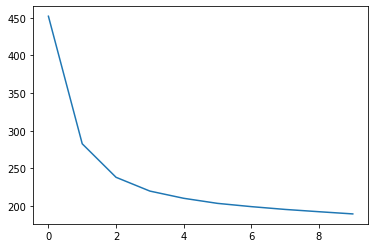

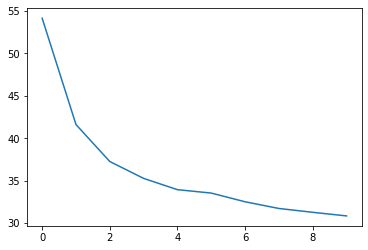

In [19]:
noise_model = NoiseAutoEncoder()
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(noise_model.parameters(), lr=1e-3)
hist = loop1(noise_model.to(device),loss_func, optimizer, trainloader,testloader,10)
show_graph(hist)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iteration number:1
train loss: 185.42297 | test loss: 30.47244
iteration number:2
train loss: 184.82609 | test loss: 30.42374
iteration number:3
train loss: 184.50461 | test loss: 30.35724
iteration number:4
train loss: 184.09770 | test loss: 30.34309
iteration number:5
train loss: 183.72436 | test loss: 30.31299
iteration number:6
train loss: 183.47859 | test loss: 30.22823
iteration number:7
train loss: 183.14663 | test loss: 30.13574
iteration number:8
train loss: 182.84024 | test loss: 30.17304
iteration number:9
train loss: 182.58220 | test loss: 30.10519
iteration number:10
train loss: 182.31552 | test loss: 30.05450
iteration number:11
train loss: 182.06082 | test loss: 29.99121
iteration number:12
train loss: 181.82103 | test loss: 29.94244
iteration number:13
train loss: 181.60788 | test loss: 29.91305
iteration number:14
train loss: 181.29861 | test loss: 29.85497
iteration number:15
train loss: 181.05388 | test loss: 29.84290
iteration number:16
train loss: 180.90864 | test 

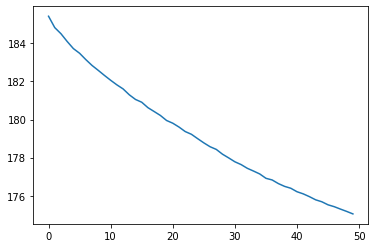

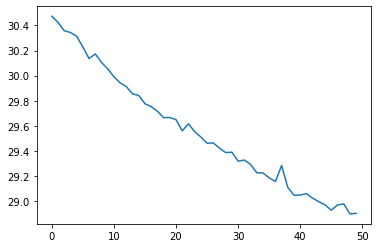

In [20]:
optimizer = torch.optim.Adam(noise_model.parameters(),lr = 1e-4)
hist = loop1(noise_model.to(device),loss_func, optimizer, trainloader,testloader,50)
show_graph(hist)

In [21]:
def check_model_work(model,dataloader):
  plt.figure(figsize=(18, 6))
  random_index = np.random.randint(0, len(dataloader),size=5)
  for i in range(5):
    #pure image
    image, label = dataloader.dataset[random_index[i]]
    im_for_model = add_noise(image)
    image = transforms.ToPILImage(mode='L')(image)
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
    #noised image
    noised_image =  transforms.ToPILImage(mode='L')(im_for_model)
    plt.subplot(3, 5, i+6)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(noised_image,cmap = "gray")
    #image from model
    image = model(im_for_model.unsqueeze(0))
    image = transforms.ToPILImage(mode='L')(image[0])
    plt.subplot(3, 5, i+11)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
  plt.show();


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


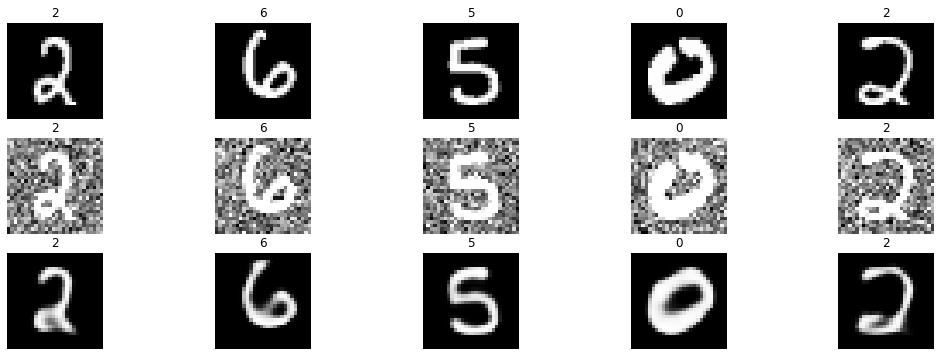

In [22]:
check_model_work(noise_model.cpu(),testloader)

Видим, что модель успешно научилась обрабатывать шум, усложним задачу, чтобы определить границу применимости модели. В данном случае яркость пикслея меняется от 0 - черный, до 1 - белый, поэтому меняя параметры нормального распределения получим разный шум.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


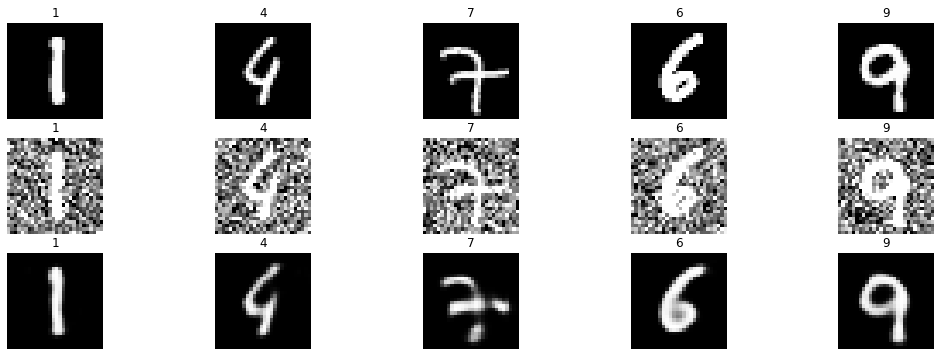

In [23]:
# Увеличение шума на 10%
def add_noise(tensor,mean=0.5,std=0.3):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


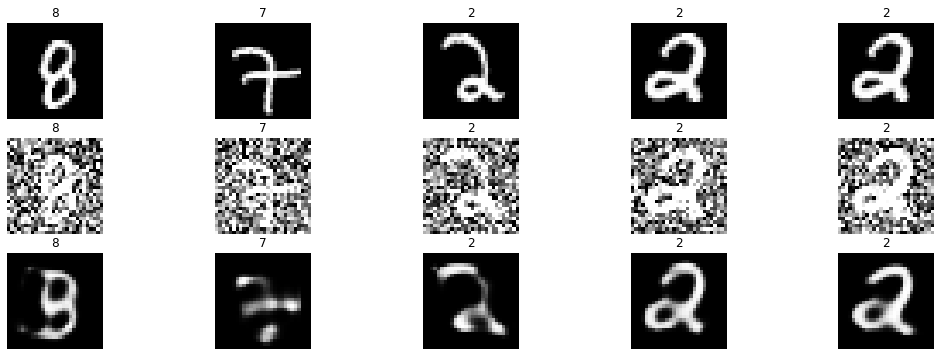

In [24]:
# Увеличение шума на 10%
def add_noise(tensor,mean=0.5,std=0.4):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


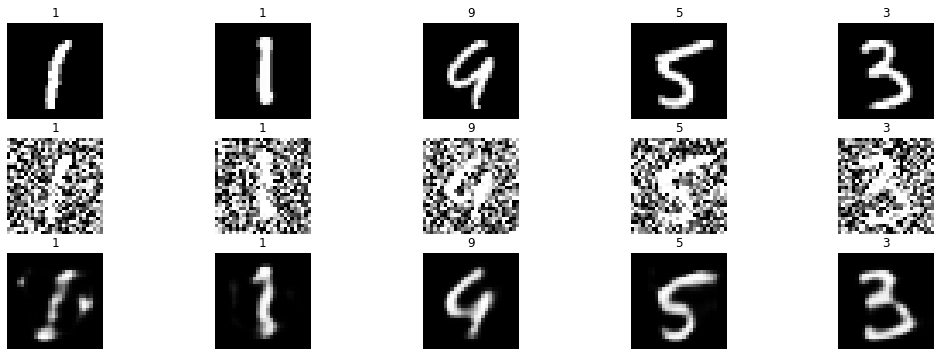

In [25]:
# Увеличение шума на 10%
def add_noise(tensor,mean=0.5,std=0.5):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

Вывод:

1.   Видно, что с добавлением шума с мат ожиданием 0.5 и стандартным отклонением 0.5 модель уже справляется хуже
2.   MSE в случае с Denoise AutoEncoder не подходит, происходит переобучение модели. Я думаю, что это связано с изначальным распределением яркости пикселей на изображении, т.е. от 0 (черный) до 1 (белый), в этом случае удобно пользоваться Cross Entropy. 



Ради эксперимента выйдем за границы разумного увеличения шума (до данного пункта шум добавлялся из нормального распределения со мат ожиданием 0.5 и стандартным отклонением от 0.3 до 0.5 (3 последних запуска модели). В данном случае попробуем поменять мат ожидание

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


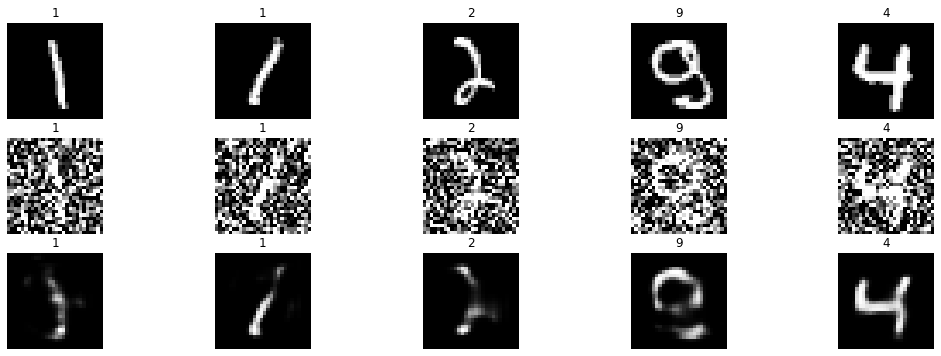

In [26]:
# мат ожидание 0.3, стандартное отклонение 0.6
def add_noise(tensor,mean=0.3,std=0.6):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


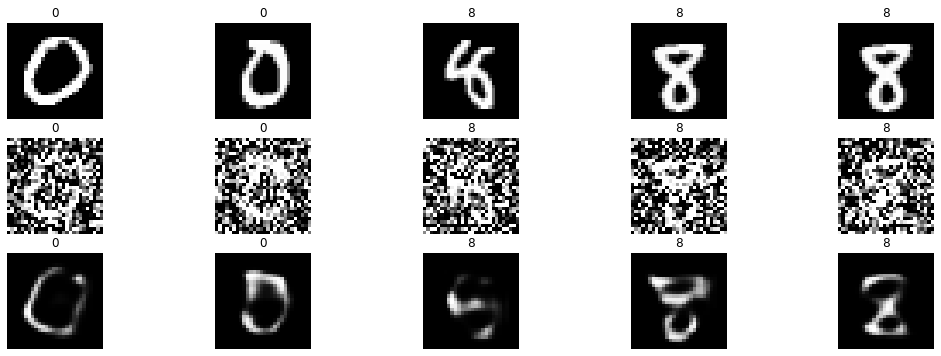

In [27]:
# мат ожидание 0.2, стандартное отклонение 0.8
def add_noise(tensor,mean=0.2,std=0.8):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

Видим, что модель научилась находить закономерности и неплохо восстанавливает данные, если шум на входе в пределах размуного.Иначе выход сети расплывчат, но и человеку сложно найти в зашумленном изображении число.

Denoising AutoEncoder для гладкой функции (например sin)

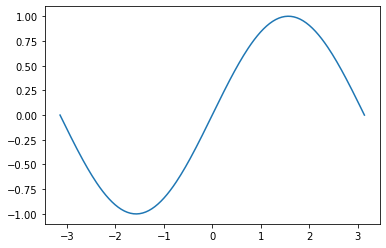

200

In [30]:
x = np.linspace(-np.pi, np.pi,200)
sin = np.sin(x)
plt.plot(x,sin)
plt.show()
len(sin)

In [31]:
class Sin_Encoder(nn.Module):
  def __init__(self):
        super(Sin_Encoder, self).__init__()

        #Encoder
        self.Encoder = nn.Sequential(nn.Linear(200,150),
                                     nn.ReLU(),
                                     nn.Linear(150,100),
                                     nn.ReLU(),
                                     nn.Linear(100,64),
                                     nn.ReLU())
        
        self.code = nn.Sequential(nn.Linear(64,64),
                                  nn.Sigmoid())

        #Decoder
        self.Decoder = nn.Sequential(nn.Linear(64,100),
                                     nn.Tanh(),
                                     nn.Linear(100,150),
                                     nn.Tanh(),
                                     nn.Linear(150,200),
                                     nn.Tanh())        


  def forward(self,x):
      x = torch.tensor(x,dtype = torch.float)
      x = self.Encoder(x)
      x = self.code(x)
      x = self.Decoder(x)
      return x

In [38]:
trainloader = testloader =  torch.utils.data.DataLoader(torch.tensor(sin, dtype = torch.float).unsqueeze(0))
device = torch.device("cpu")
print(device)

cpu


In [39]:
def add_noise_sin(sin, mean = 0, std = 0.2):
    # Мат ожидание loc, стандартное отклонение scale
    return torch.tensor(sin + np.random.normal(size = sin.shape, loc = mean, scale = std), dtype=torch.float)

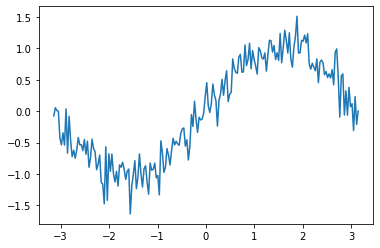

In [40]:
plt.plot(x,add_noise_sin(sin))
plt.show()

In [42]:
def noise_train_mode(model, criterion, optim, loader):
  train_loss = 0
  model.train()
  for data in loader:
    noise_sin = add_noise_sin(data)
    optim.zero_grad()
    pred = model(noise_sin)
    loss = criterion(pred,torch.tensor(data,dtype=torch.float))
    loss.backward()
    optim.step()
    train_loss += loss.item()
  return train_loss

def noise_test_mode(model, criterion, loader):
  test_loss = 0
  model.eval()
  for data in loader:
    noise_sin = add_noise_sin(data)
    with torch.set_grad_enabled(False):
      pred = model(noise_sin)
      loss = criterion(pred,data)
      test_loss += loss.item() 
  return test_loss

def sin_loop(model, criterion, optim, train_loader, test_loader, num_epochs):
  hist = []
  for epoch in (range(num_epochs)):
    train = noise_train_mode(model, criterion, optim, train_loader)
    test = noise_test_mode(model, criterion, test_loader)
    print(f"iteration number:{epoch + 1}")
    print("train loss: {:.5f} | test loss: {:.5f}".format(train, test))
    hist.append((train,test))
    
  return hist

iteration number:1
train loss: 0.51427 | test loss: 0.49900
iteration number:2
train loss: 0.49898 | test loss: 0.48403
iteration number:3
train loss: 0.48404 | test loss: 0.46932
iteration number:4
train loss: 0.46935 | test loss: 0.45484
iteration number:5
train loss: 0.45485 | test loss: 0.44047
iteration number:6
train loss: 0.44047 | test loss: 0.42611
iteration number:7
train loss: 0.42612 | test loss: 0.41160
iteration number:8
train loss: 0.41155 | test loss: 0.39697
iteration number:9
train loss: 0.39698 | test loss: 0.38227
iteration number:10
train loss: 0.38219 | test loss: 0.36724
iteration number:11
train loss: 0.36728 | test loss: 0.35205
iteration number:12
train loss: 0.35200 | test loss: 0.33655
iteration number:13
train loss: 0.33655 | test loss: 0.32093
iteration number:14
train loss: 0.32088 | test loss: 0.30483
iteration number:15
train loss: 0.30487 | test loss: 0.28859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


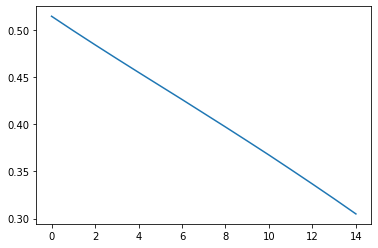

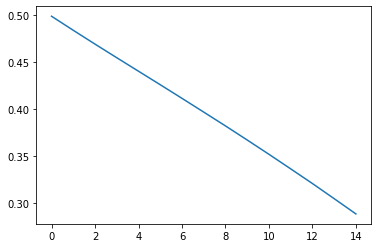

In [43]:
model = Sin_Encoder()
optimizer = torch.optim.Adam(model.parameters(),lr = 3e-4)
loss_func = nn.MSELoss()
hist = sin_loop(model.to(device),loss_func, optimizer, trainloader,testloader,15)
show_graph(hist)

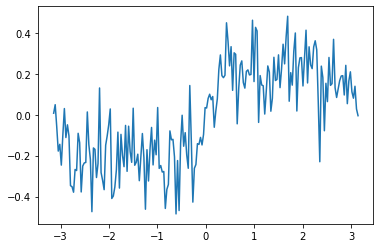

In [44]:
plt.plot(x,model(sin).detach())
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration number:1
train loss: 0.28856 | test loss: 0.27225
iteration number:2
train loss: 0.27224 | test loss: 0.25578
iteration number:3
train loss: 0.25589 | test loss: 0.23958
iteration number:4
train loss: 0.23936 | test loss: 0.22272
iteration number:5
train loss: 0.22279 | test loss: 0.20647
iteration number:6
train loss: 0.20669 | test loss: 0.19039
iteration number:7
train loss: 0.19071 | test loss: 0.17514
iteration number:8
train loss: 0.17476 | test loss: 0.15951
iteration number:9
train loss: 0.15918 | test loss: 0.14504
iteration number:10
train loss: 0.14487 | test loss: 0.13129
iteration number:11
train loss: 0.13106 | test loss: 0.11771
iteration number:12
train loss: 0.11781 | test loss: 0.10524
iteration number:13
train loss: 0.10551 | test loss: 0.09366
iteration number:14
train loss: 0.09368 | test loss: 0.08282
iteration number:15
train loss: 0.08300 | test loss: 0.07328
iteration number:16
train loss: 0.07343 | test loss: 0.06491
iteration number:17
train loss: 0

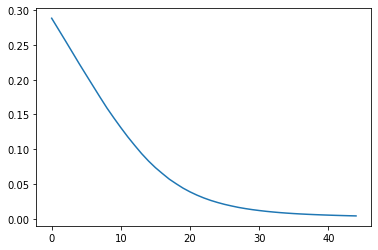

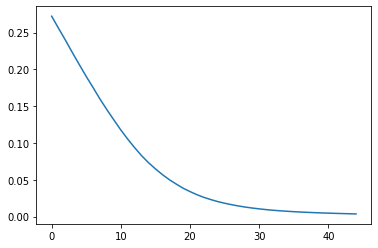

In [46]:
hist = sin_loop(model.to(device),loss_func, optimizer, trainloader,testloader,45)
show_graph(hist)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


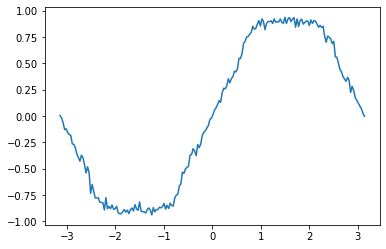

In [47]:
plt.plot(x,model(add_noise_sin(sin)).detach())
plt.show()

In [48]:
hist = sin_loop(model.to(device),loss_func, optimizer, trainloader,testloader,50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration number:1
train loss: 0.00370 | test loss: 0.00349
iteration number:2
train loss: 0.00349 | test loss: 0.00328
iteration number:3
train loss: 0.00328 | test loss: 0.00309
iteration number:4
train loss: 0.00310 | test loss: 0.00292
iteration number:5
train loss: 0.00292 | test loss: 0.00276
iteration number:6
train loss: 0.00276 | test loss: 0.00261
iteration number:7
train loss: 0.00261 | test loss: 0.00246
iteration number:8
train loss: 0.00247 | test loss: 0.00233
iteration number:9
train loss: 0.00233 | test loss: 0.00221
iteration number:10
train loss: 0.00221 | test loss: 0.00209
iteration number:11
train loss: 0.00209 | test loss: 0.00198
iteration number:12
train loss: 0.00198 | test loss: 0.00187
iteration number:13
train loss: 0.00187 | test loss: 0.00177
iteration number:14
train loss: 0.00177 | test loss: 0.00169
iteration number:15
train loss: 0.00169 | test loss: 0.00160
iteration number:16
train loss: 0.00160 | test loss: 0.00153
iteration number:17
train loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


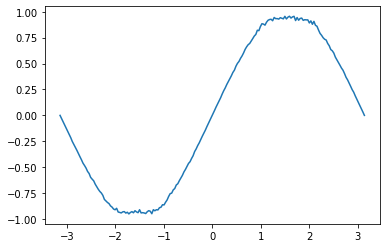

In [49]:
plt.plot(x,model(add_noise_sin(sin)).detach())
plt.show()

Denoise AutoEncoder успешно научился убирать шум с входного сигнала. Выход декодера не соотвествует введенным данным, что очевидно. Конечно можно заставить модель "запомнить" сигнал, тогда получим идеальный синус.

In [51]:
hist = sin_loop(model.to(device),loss_func, optimizer, trainloader,testloader,1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration number:1
train loss: 0.00056 | test loss: 0.00055
iteration number:2
train loss: 0.00055 | test loss: 0.00055
iteration number:3
train loss: 0.00054 | test loss: 0.00053
iteration number:4
train loss: 0.00053 | test loss: 0.00052
iteration number:5
train loss: 0.00052 | test loss: 0.00051
iteration number:6
train loss: 0.00051 | test loss: 0.00050
iteration number:7
train loss: 0.00049 | test loss: 0.00049
iteration number:8
train loss: 0.00049 | test loss: 0.00048
iteration number:9
train loss: 0.00048 | test loss: 0.00048
iteration number:10
train loss: 0.00047 | test loss: 0.00047
iteration number:11
train loss: 0.00046 | test loss: 0.00045
iteration number:12
train loss: 0.00046 | test loss: 0.00044
iteration number:13
train loss: 0.00045 | test loss: 0.00044
iteration number:14
train loss: 0.00044 | test loss: 0.00043
iteration number:15
train loss: 0.00043 | test loss: 0.00042
iteration number:16
train loss: 0.00042 | test loss: 0.00041
iteration number:17
train loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


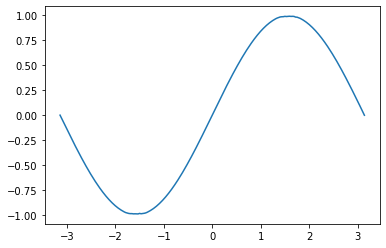

In [52]:
plt.plot(x,model(add_noise_sin(sin)).detach())
plt.show()